In [86]:
#instructions

#Requires ROS
#pip install numpy
#pip install matplotlib
#pip install ipyml
#pip install ipython
#pip install tqdm


%matplotlib widget

import rosbag
import rospy
import numpy as np
import matplotlib.pyplot as plt
import message_filters
from tqdm import tqdm

In [87]:
topics = ['/slave1/image_raw/compressed', '/slave2/image_raw/compressed']

#initial rosbag with image not perfectly synchronized
bag_filename = '/home/bjoshi/Downloads/test.bag'

#synchronized rosbag
output_filename = '/home/bjoshi/Downloads/pamir_sync.bag'

cache_size = 100
slop = 0.02
left_stamps = []    
right_stamps = []
common_stamps = []

rospy.init_node('stereo_sync_test')
input_bag = rosbag.Bag(bag_filename, 'r')
output_bag = rosbag.Bag(output_filename, 'w')

stamps = open('stamps.txt', 'w')
stamps.write('Left [ns] , Right [ns] , Common [ns]\n')

37

In [88]:
#Callback to calculate the time difference between the left and right camera
# Also, write the left and right images with mean on the time stamps

def stereo_callback(left_msg, right_msg):
    # Matches timestamps in left and right messages
    new_nsecs = np.double(left_msg.header.stamp.to_nsec() +
                       right_msg.header.stamp.to_nsec())/2.0
    new_stamp = rospy.Time(nsecs=new_nsecs)


    #writing for post processing if needed
    stamps.write(
        f"{str(left_msg.header.stamp.to_nsec())},{str(right_msg.header.stamp.to_nsec())},{new_stamp.to_nsec()}\n")

    left_stamps.append(left_msg.header.stamp.to_nsec())
    right_stamps.append(right_msg.header.stamp.to_nsec())
    common_stamps.append(new_stamp.to_nsec())

    left_msg.header.stamp = new_stamp
    right_msg.header.stamp = new_stamp

    output_bag.write(topics[0], left_msg, new_stamp)
    output_bag.write(topics[1], right_msg, new_stamp)


In [89]:
filters = [message_filters.SimpleFilter() for _ in topics]
sync_filter = message_filters.ApproximateTimeSynchronizer(filters, cache_size, slop)
sync_filter.registerCallback(stereo_callback)
    
for topic, msg, t in tqdm(input_bag.read_messages(), total=input_bag.get_message_count()):
    if topic in topics:
        filters[topics.index(topic)].signalMessage(msg)
    else:
        output_bag.write(topic, msg, t)

input_bag.close()
output_bag.close()
stamps.close()

100%|██████████| 53932/53932 [00:03<00:00, 13693.65it/s]


### Now testing some synchonization

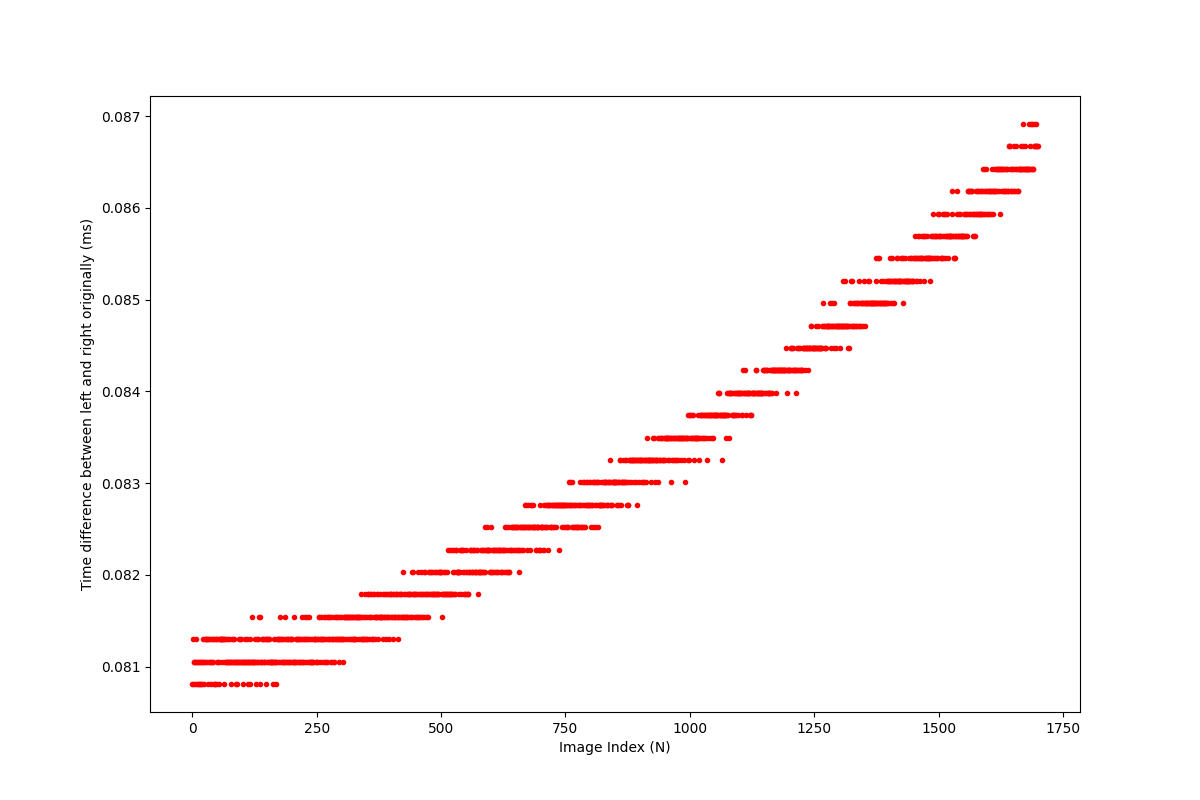

In [90]:
left_millis = np.array(left_stamps) / 1e6
right_millis = np.array(right_stamps) / 1e6
common_millis = np.array(common_stamps) / 1e6

original_diff_millis = np.array(right_millis - left_millis)

indicies = np.arange(len(left_millis))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('Image Index (N)')
ax.set_ylabel('Time difference between left and right originally (ms)')
ax.scatter(indicies, original_diff_millis, color='r', marker='.')

## Comments
 - There is some drift as images get asynchronized with time
 - However, the drift is less than 1ms
 - Next want to check if all things are written with good order and syncronization

### Plotting the time difference between left and common time stamp after synchronization

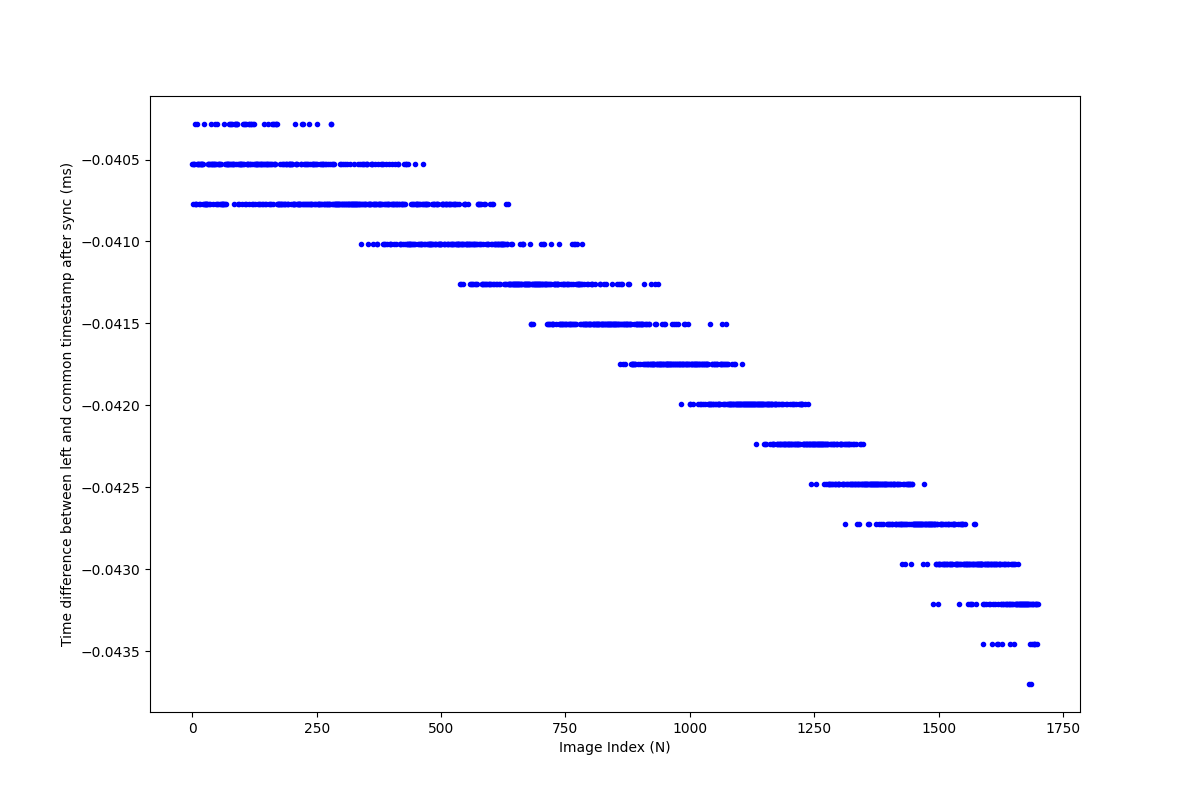

In [91]:
common_left_millis = np.array(left_millis - common_millis)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('Image Index (N)')
ax.set_ylabel('Time difference between left and common timestamp after sync (ms)')
ax.scatter(indicies, common_left_millis, color='b', marker='.')


### Plotting the time difference between right and common time stamp after synchronization

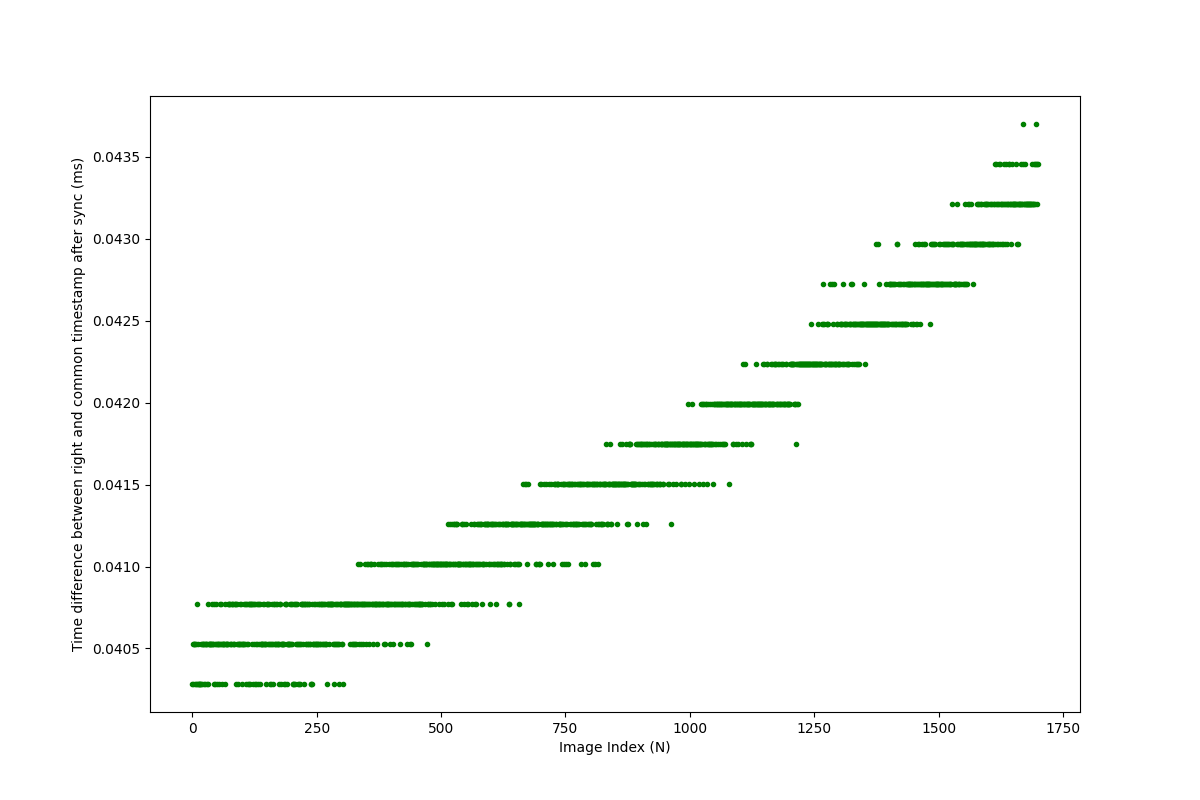

In [92]:
common_right_millis = np.array(right_millis - common_millis)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('Image Index (N)')
ax.set_ylabel(
    'Time difference between right and common timestamp after sync (ms)')
ax.scatter(indicies, common_right_millis, color='g', marker='.')


## Some additional cross check to see if the images are written to bag file with correct stamps 

In [93]:
# Reading stamps from the output file and check if everything written correctly

left_final_stamps = []
right_final_stamps = []

with rosbag.Bag(output_filename, 'r') as bag:
    for topic, msg, t in bag.read_messages():
        if topic == '/slave1/image_raw/compressed':
            left_final_stamps.append(msg.header.stamp.to_nsec())
        elif topic == '/slave2/image_raw/compressed':
            right_final_stamps.append(msg.header.stamp.to_nsec())


assert(left_final_stamps == common_stamps)
assert(right_final_stamps == common_stamps)